In [31]:
import os
import pcapy as p
from scapy.all import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import struct


In [32]:
data = "../ft600-txtest-icezero/66Mhz_B.pcapng"

In [33]:
packets = rdpcap(data)
Config = []
IMGS = []
IMGSsmol = []
idxImags = []
IMGS2 = []
IMGSsmol2 = []
idxImags2 = []
start = 0
ix = 1
for k in packets:
    k = k[Raw].load
    if k[8] == 0x53: # URB submit
        if k[9] == 0x02: # URB submit
            TYPE = "URB_CONTROL"
        elif k[9] == 0x03: # BULK
            TYPE = "BULK"
        else:
            TYPE = "OTHER"
        EP = k[10] # EP
        if EP == 0:
            SENS ="OUT"
        elif EP ==130:
            SENS = "IN"
        elif EP==1:
            SENS = "OUT"
        else:
            SENS = "IN"
            
        if TYPE == "BULK":
            sizeRequested = k[33]*256+k[32] 
            DIC = {'ID': ix,"Sens":SENS,"TYPE":TYPE,"EP":k[10],"sizeRequested":sizeRequested,"LEN":len(k)}
        else:
            bmRequestType = k[40]
            bmRequest = k[41]
            bmValue  =  256*k[43]+k[42] 
            bmIndex  = k[44]+256*k[45]  
            bmLength =  k[46]+256*k[47]  

            #print(ix,hex(bmRequestType),bmRequest,hex(bmValue),bmIndex,bmLength,TYPE,SENS,hex(EP))
            DIC = {'ID': ix,"Sens":SENS,"TYPE":TYPE,"EP":k[10],"bmRequestType":bmRequestType,
                           "bmRequest":bmRequest,"bmValue":bmValue,"bmIndex":bmIndex,"bmLength":bmLength,"LEN":len(k)
                   }
        if len(k) > 64:
            DIC["payload"] = k[64:]
        Config.append(DIC)
            
    if k[8] == 0x43: # URB receive
        if 0:
            if (len(k) == 65):
                print(ix,hex(k[-1]))
            if (len(k) == 66):
                print(ix,hex(k[-1]+256*k[-2]  ))
                
    if (k[8] == 0x43) & ((k[10] == 0x86)): # URB receive  
        if len(k) > 20000:
            IMGS.append(k[64:])
            #print(ix)
            idxImags.append(str(ix)+"full")
        else:
            IMGSsmol.append(k[64:])
            idxImags.append(str(ix)+"short")
    if (k[8] == 0x43) & ((k[10] == 0x82)): # URB receive  
        if len(k) > 20000:
            IMGS2.append(k[64:])
            #print(ix)
            idxImags2.append(str(ix)+"full")
        else:
            IMGSsmol2.append(k[64:])
            idxImags2.append(str(ix)+"short")   
    ix +=1

In [34]:
df = pd.DataFrame(Config) 
DF = df.drop_duplicates(subset=["bmRequestType","bmRequest","bmValue","bmIndex","bmLength","sizeRequested","payload"])#.sort_values(by=["bmRequest","bmValue"])
print( len(df),len(DF) )
DF.to_pickle("conf.pkl")
DF

195 13


,ID,Sens,TYPE,EP,bmRequestType,bmRequest,bmValue,bmIndex,bmLength,LEN,payload,sizeRequested
0,1,IN,URB_CONTROL,128,128.0,6.0,768.0,0.0,255.0,64,NaN,NaN
1,3,IN,URB_CONTROL,128,128.0,6.0,771.0,1033.0,255.0,64,NaN,NaN
3,7,IN,URB_CONTROL,128,128.0,6.0,770.0,1033.0,255.0,64,NaN,NaN
4,9,IN,URB_CONTROL,128,192.0,241.0,0.0,0.0,4.0,64,NaN,NaN
5,11,IN,URB_CONTROL,128,192.0,3.0,1.0,33792.0,4.0,64,NaN,NaN
6,13,IN,URB_CONTROL,128,192.0,3.0,1.0,32768.0,4.0,64,NaN,NaN
7,15,OUT,URB_CONTROL,0,64.0,3.0,1.0,32768.0,4.0,68,b'\x00\x02!\x01',NaN
8,17,IN,URB_CONTROL,128,192.0,207.0,1.0,0.0,152.0,64,NaN,NaN
9,19,OUT,BULK,1,NaN,NaN,NaN,NaN,NaN,84,b'\x00\x00\x00\x00\x02\x02\x00\x00\x00\x00\x00...,20.0
10,21,OUT,BULK,1,NaN,NaN,NaN,NaN,NaN,84,b'\x00\x00\x00\x00\x82\x03\x00\x00\x00\x00\x00...,20.0


# Replays

In [35]:
#USB
import usb.core
import usb.util 
# Figures
import pandas as pd
import numpy as np
# Utilities
import json, sys
import base64
import struct

In [36]:
device = usb.core.find(idVendor=0x0403, idProduct=0x601e)
    # initialize device
#usb.util.dispose_resources(device)

for config in device:  
    # The device was getting "Err 16 busy" on my ubuntu
    for i in range(config.bNumInterfaces):
        if device.is_kernel_driver_active(i):
            device.detach_kernel_driver(i) 
device.reset()

try:
    device.set_configuration()
except:
    print("Already connected")
                
try:
    device.set_configuration()
    device.reset()
except usb.core.USBError as e:
    sys.exit("Cannot set configuration the device: %s" % str(e))
    
# find first USBTMC interface
IFS = []
for cfg in device:
    for iface in cfg:
        #print(iface)
        IFS.append(iface)

device.set_configuration(cfg)
EP = []
# claim interface
for iface in IFS:
    print(" IFACE-> ")
    usb.util.claim_interface(device, iface)

    # don't need to set altsetting - USBTMC devices have 1 altsetting as per the spec

    
    for ep in iface:
        ep_dir = usb.util.endpoint_direction(ep.bEndpointAddress)
        ep_type = usb.util.endpoint_type(ep.bmAttributes)
        EP.append(ep)
        print(ep)

 IFACE-> 
      ENDPOINT 0x1: Bulk OUT ===============================
       bLength          :    0x7 (7 bytes)
       bDescriptorType  :    0x5 Endpoint
       bEndpointAddress :    0x1 OUT
       bmAttributes     :    0x2 Bulk
       wMaxPacketSize   :  0x400 (1024 bytes)
       bInterval        :    0x0
      ENDPOINT 0x81: Interrupt IN ==========================
       bLength          :    0x7 (7 bytes)
       bDescriptorType  :    0x5 Endpoint
       bEndpointAddress :   0x81 IN
       bmAttributes     :    0x3 Interrupt
       wMaxPacketSize   :   0x40 (64 bytes)
       bInterval        :    0x9
 IFACE-> 
      ENDPOINT 0x2: Bulk OUT ===============================
       bLength          :    0x7 (7 bytes)
       bDescriptorType  :    0x5 Endpoint
       bEndpointAddress :    0x2 OUT
       bmAttributes     :    0x2 Bulk
       wMaxPacketSize   :  0x400 (1024 bytes)
       bInterval        :    0x0
      ENDPOINT 0x82: Bulk IN ===============================
       bLength   

In [37]:
EP

[<ENDPOINT 0x1: Bulk OUT>,
 <ENDPOINT 0x81: Interrupt IN>,
 <ENDPOINT 0x2: Bulk OUT>,
 <ENDPOINT 0x82: Bulk IN>]

In [38]:
DF

,ID,Sens,TYPE,EP,bmRequestType,bmRequest,bmValue,bmIndex,bmLength,LEN,payload,sizeRequested
0,1,IN,URB_CONTROL,128,128.0,6.0,768.0,0.0,255.0,64,NaN,NaN
1,3,IN,URB_CONTROL,128,128.0,6.0,771.0,1033.0,255.0,64,NaN,NaN
3,7,IN,URB_CONTROL,128,128.0,6.0,770.0,1033.0,255.0,64,NaN,NaN
4,9,IN,URB_CONTROL,128,192.0,241.0,0.0,0.0,4.0,64,NaN,NaN
5,11,IN,URB_CONTROL,128,192.0,3.0,1.0,33792.0,4.0,64,NaN,NaN
6,13,IN,URB_CONTROL,128,192.0,3.0,1.0,32768.0,4.0,64,NaN,NaN
7,15,OUT,URB_CONTROL,0,64.0,3.0,1.0,32768.0,4.0,68,b'\x00\x02!\x01',NaN
8,17,IN,URB_CONTROL,128,192.0,207.0,1.0,0.0,152.0,64,NaN,NaN
9,19,OUT,BULK,1,NaN,NaN,NaN,NaN,NaN,84,b'\x00\x00\x00\x00\x02\x02\x00\x00\x00\x00\x00...,20.0
10,21,OUT,BULK,1,NaN,NaN,NaN,NaN,NaN,84,b'\x00\x00\x00\x00\x82\x03\x00\x00\x00\x00\x00...,20.0


In [39]:
DF["payload"] = DF.payload.fillna(-1)
for index, row in DF.iterrows():
    if row["TYPE"] == "URB_CONTROL":
        bmRT = int(row["bmRequestType"])
        bmR = int(row["bmRequest"])
        wV = int(row["bmValue"])
        wI = int(row["bmIndex"])
        
        if row["payload"] == -1: 
            PL = int(row["bmLength"])
        else: 
            PL = row["payload"]
            
        print("#",row["ID"]," ",bmRT,bmR,wV,wI,PL)
        m = device.ctrl_transfer(bmRequestType= bmRT,bRequest= bmR, wValue= wV, wIndex= wI , data_or_wLength=  PL)
        print(m)
print("Done")




# 1   128 6 768 0 255
array('B', [4, 3, 9, 4])
# 3   128 6 771 1033 255
array('B', [26, 3, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 49, 0])
# 7   128 6 770 1033 255
array('B', [56, 3, 70, 0, 84, 0, 68, 0, 73, 0, 32, 0, 83, 0, 117, 0, 112, 0, 101, 0, 114, 0, 83, 0, 112, 0, 101, 0, 101, 0, 100, 0, 45, 0, 70, 0, 73, 0, 70, 0, 79, 0, 32, 0, 66, 0, 114, 0, 105, 0, 100, 0, 103, 0, 101, 0])
# 9   192 241 0 0 4
array('B', [9, 1, 0, 0])
# 11   192 3 1 33792 4
array('B', [0, 1, 23, 0])
# 13   192 3 1 32768 4
array('B', [0, 1, 1, 1])
# 15   64 3 1 32768 b'\x00\x02!\x01'
4
# 17   192 207 1 0 152
array('B', [3, 4, 30, 96, 10, 3, 70, 0, 84, 0, 68, 0, 73, 0, 56, 3, 70, 0, 84, 0, 68, 0, 73, 0, 32, 0, 83, 0, 117, 0, 112, 0, 101, 0, 114, 0, 83, 0, 112, 0, 101, 0, 101, 0, 100, 0, 45, 0, 70, 0, 73, 0, 70, 0, 79, 0, 32, 0, 66, 0, 114, 0, 105, 0, 100, 0, 103, 0, 101, 0, 26, 3, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 48, 0, 49, 0, 0, 0, 0, 0, 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
DF["payload"] = DF.payload.fillna(-1)
for index, row in DF.iterrows():
    if row["ID"] in [19,21,31]:
        
        PL = row["payload"]
             
        m = EP[0].write(PL)
        print(m)
print("Done")

20
20
20
Done


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
data = []
t = []
while 1:
    data.append(EP[-1].read(2048))
    t.append(time.time())

USBError: [Errno 75] Overflow

In [42]:
len(data)

6181

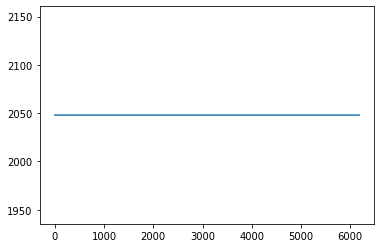

In [43]:
plt.plot([len(x) for x in data])

# Checks

In [49]:
t[-1]-t[0],"s"

(3.127227783203125, 's')

In [46]:
len(data)*len(data[0]),"bytes transfered"

(12658688, 'bytes transfered')

In [48]:
len(data)*len(data[0])/(t[-1]-t[0])/1024/1024,"Mo/s"

3.860372976296195